In [46]:
from mphelper import ProcessWrapPool
import pybedtools
import subprocess
import pandas as pd
from collections import defaultdict, Counter
from biodata.delimited import DelimitedReader, DelimitedWriter
import biodataplot.genomeview as gv
import biodataplot.utils as bpu
import matplotlib
import matplotlib.pyplot as plt
import biodataplot.metaplot as bpm
from biodata.bigwig import BigWigIReader
from biodata.bed import BEDXReader
from genomictools import GenomicCollection
import seaborn as sns
from biodatatools.utils.common import json_load
import numpy as np
from pathlib import Path
import sys
import itertools
import matplotlib.lines as mlines

In [48]:
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9
lw = 0.8

In [17]:
sys.path.append(str(Path.cwd().parent))
import utils

In [4]:
PROJECT_DIR_d = "/fs/cbsuhy02/storage/kl945/EnhancerAtlas/Others/"
PROJECT_DIR_d2 = "/home/yc2553/projects/HEA/databases/"
PROJECT_DIR_d3 = "/fs/cbsuhy02/storage/yc2553/yc2553/databases/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/"
PROJECT_DIR_o2 = "/home/yc2553/projects/HEA/output/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"

# CRISPR data

In [5]:
# Get CRISPR data from Russel Ryan group

samples = ["K562", "SEM", "REH", "NALM-6", "Karpas422", "SUDHL5"]

In [6]:
bedgraphs = {}
for s in samples:
    if s != "SUDHL5":
        s2 = "Nalm6" if s == "NALM-6" else s
        bedgraphs[s] = f"{PROJECT_DIR_d}collaborators_Haiyuan_Yu_lab_{s2}_MYC.filt.norm.hg38lo.bedgraph"
    else:
        bedgraphs[s] = f"{PROJECT_DIR_d}collaborators_Haiyuan_Yu_lab_hg38lo.Lib12_134_common_Ci_Sudhl-5.bedgraph"

In [7]:
# SUDHL5: different experimental design

for s in samples:
    print(s, Counter([int(i.fields[2])-int(i.fields[1]) for i in pybedtools.BedTool(bedgraphs[s])]))

K562 Counter({25: 48321, 24: 1})
SEM Counter({25: 53781, 24: 1})
REH Counter({25: 53765, 24: 1})
NALM-6 Counter({25: 53685, 24: 1})
Karpas422 Counter({25: 48333, 24: 1})
SUDHL5 Counter({1: 12160})


In [8]:
# ~3Mb
# Note some intervals have missing values

p_lefts = []
p_rights = []
results = []
for s in samples:
    b = pybedtools.BedTool(bedgraphs[s])
    p_left, p_right = np.min([int(i.fields[1]) for i in b]), np.max([int(i.fields[1]) for i in b])
    non_NA = len([i for i in b if len(i.fields)==4])
    results.append([s, 
                  non_NA, len(b)-non_NA,
                  p_left, p_right]
                 )
    p_lefts.append(p_left)
    p_rights.append(p_right)
pd.DataFrame(results, columns=["sample", "No. intervals with values", "No. intervals w/o values", "Leftmost position", "Rightmost position"])

,sample,No. intervals with values,No. intervals w/o values,Leftmost position,Rightmost position
0,K562,48300,22,127128530,129731879
1,SEM,53742,40,127034980,129836104
2,REH,53726,40,127034980,129836104
3,NALM-6,53646,40,127034980,129836104
4,Karpas422,48313,21,127128530,129731879
5,SUDHL5,12160,0,3797476,235329617


In [9]:
# Check the positions of intervals with missing values
# These intervals are located at the far ends, also not overlapping with PRO-cap elements; no need to worry about this...

for s in samples:
    outputfile = f"{PROJECT_DIR_d2}/CRISPR/{s}_MYC_missing.bed"
    with DelimitedWriter(outputfile) as dw:
        with DelimitedReader(bedgraphs[s]) as dr:
            for cols in dr:
                if len(cols) == 3:
                    dw.write(cols)
    b = pybedtools.BedTool(outputfile).merge()
    b.sort().saveas(outputfile)
    print(s, [tuple(i.fields[:3]) for i in b])

K562 [('chr8', '127128530', '127128730'), ('chr8', '129731554', '129731904')]
SEM [('chr8', '127034980', '127035430'), ('chr8', '129835454', '129835979'), ('chr8', '129836104', '129836129')]
REH [('chr8', '127034980', '127035430'), ('chr8', '129835454', '129835979'), ('chr8', '129836104', '129836129')]
NALM-6 [('chr8', '127034980', '127035430'), ('chr8', '129835454', '129835979'), ('chr8', '129836104', '129836129')]
Karpas422 [('chr8', '127128530', '127128705'), ('chr8', '129731554', '129731904')]
SUDHL5 []


In [10]:
# Filter out intervals with missing values for plotting

for s in samples:
    outputfile = f"{PROJECT_DIR_d2}/CRISPR/{s}_MYC.bedgraph"
    with DelimitedWriter(outputfile) as dw:
        with DelimitedReader(bedgraphs[s]) as dr:
            for cols in dr:
                if len(cols) == 4:
                    dw.write(cols)

# Active rate

In [11]:
# Only include elements fully embedded within this region

boundary = np.max(p_lefts), np.min(p_rights)
inputfile = f"{PROJECT_DIR_o2}homer/LL/bg.bed"
b = pybedtools.BedTool(inputfile)
es_all = [i.fields[:3] for i in b if i.fields[0] == "chr8" and int(i.fields[1]) >= boundary[0] and int(i.fields[2]) <= boundary[1]]
len(es_all)

88

In [12]:
# No tiling screen for OCI-LY7, SUDHL5 and Pfeiffer

ms = [f"M{n}" for n in range(1,11) if n not in [7,8,10]]

In [13]:
# Get elements from each module within this region

mes = {}
for m in ms:
    inputfile = f"{PROJECT_DIR_o2}homer/LL/{m}.bed"
    b = pybedtools.BedTool(inputfile)
    mes[m] = [i.fields[:3] for i in b if i.fields[:3] in es_all]
    outputfile = f"{PROJECT_DIR_d2}CRISPR/{m}_MYC.bed"
    with DelimitedWriter(outputfile) as dw:
        print(m, len(mes[m]))
        for e in mes[m]:
            dw.write(e)

M1 23
M2 10
M3 5
M4 4
M5 8
M6 10
M9 3


In [14]:
# Significant peaks from tiling screen

sig_peaks = {}
for s in samples:
    if s != "SUDHL5":
        s2 = "Nalm6" if s == "NALM-6" else s
        sig_peaks[s] = f"{PROJECT_DIR_d2}CRISPR/{s2}_fdr.utest_0.05_l2fc_mean_0.4_mrg.9col.hg38lo.bed"

In [15]:
# Heatmap
# Each row: different modules
# Each column: different cell lines
# Cell: active rate (depletion)

active_rates = {}
active_es = defaultdict(list)
for m in ms:
    b1 = pybedtools.BedTool(f"{PROJECT_DIR_d2}CRISPR/{m}_MYC.bed")
    for s in sig_peaks:
        b2 = pybedtools.BedTool(sig_peaks[s])
        # -f: Minimum overlap required as a fraction of A.
        overlap = b1.intersect(b2, f=0.5, wao=True)
        n_pos = 0
        for i in overlap:
            if int(i.fields[-1]) > 0 and i.fields[-2] == "#0000FF":
                n_pos += 1
                active_es[(m, s)].append("_".join(i.fields[:3]))
        active_rates[(m, s)] = [n_pos, len(b1), n_pos/len(b1)]

In [16]:
results = []
for m in ms:
    row = [active_rates[(m, s)][-1] for s in sig_peaks]
    results.append(row)
df_rate = pd.DataFrame(results, columns=list(sig_peaks), index = ms)
df_rate.head(2)

,K562,SEM,REH,NALM-6,Karpas422
M1,0.304348,0.086957,0.0,0.0,0.0
M2,0.000000,0.600000,0.7,0.3,0.0


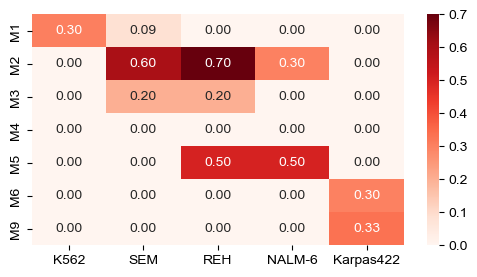

In [19]:
fig, ax = plt.subplots(figsize=(6,3))
g = sns.heatmap(data=df_rate, cmap="Reds", annot=True, fmt=".2f", ax=ax)

In [20]:
subtypes = ["CML", "B-ALL", "GCB-DLBCL"]
colors = ["#969696", "#fdb462", "#fb8072"]

In [21]:
labels = json_load(f"{PROJECT_DIR_d2}PROcap/metainfo/classifications.json")
sample_colors = [colors[subtypes.index(labels[s][1])] for s in sig_peaks]

In [22]:
results = []
for m in ms:
    for s in sig_peaks:
        results.append([s, m]+active_rates[(m,s)])
df_bar = pd.DataFrame(results, columns=["sample", "module", "n_pos", "n_tot", "active_rate"])

In [ ]:
fig, ax = plt.subplots(figsize=(3.5,2))

m = "M2"
df = df_bar[df_bar["module"]==m]
g = sns.barplot(data=df, x="sample", y="active_rate", hue="sample", palette=sample_colors, ax=ax)
g.set_title(m, fontsize=bfontsize)
g.spines[["top","right"]].set_visible(False)

g.set_ylabel("Active rate", fontsize=bfontsize)
g.tick_params(axis="y", labelsize=sfontsize)
g.set_ylim([0,0.85])

g.set_xlabel("")
g.tick_params(axis="x", labelsize=bfontsize, rotation=30)
for label in g.get_xticklabels():
    label.set_ha("right")

labs = [f"{pos}/{tot}" for pos, tot in zip(df["n_pos"], df["n_tot"])]
for bar, lbl in zip(g.patches, labs):
    height = bar.get_height()
    g.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.02,
        lbl,
        ha="center",
        va="bottom",
        fontsize=sfontsize
    )
for label, color in zip(g.get_xticklabels(), sample_colors):
    label.set_color(color)

plt.savefig(f"{PROJECT_DIR_o2}figures/ExtDataFig9b.pdf", bbox_inches="tight", transparent=True)

# Examples

## Candidate regions

In [32]:
regions = [
            # M1
            ("chr8", "127897918", "127900416"),
            # divergent proximal
            ("chr8", "127959178", "127961676"),
            # divergent proximal
            ("chr8", "128047678", "128050176"),
            # M1
            ("chr8", "129691488", "129693986"),
            # M1, M3 (BENC-C)
            ("chr8", "129581099", "129583597"),
            # M2 (BENC-D)
            ("chr8", "129590844", "129593342"),
            # divergent proximal
            ("chr8", "129678102", "129680600"),
            # M6 (GME-1)
            ("chr8", "128171008", "128173506"),
            # No PRO-cap elements
            # ("chr8", "128628131", "128630629"),
            # M9, M10
            ("chr8", "128076455", "128078953")
          ]

In [33]:
outputfile = f"{PROJECT_DIR_d2}CRISPR/candidate_regions.bed"
with DelimitedWriter(outputfile) as dw:
    for r in regions:
        dw.write(r)

In [34]:
b1 = pybedtools.BedTool(f"{PROJECT_DIR_d2}CRISPR/candidate_regions.bed")
for n in range(1, 11):
    b2 = pybedtools.BedTool(f"{PROJECT_DIR_o2}homer/LL/M{n}.bed")
    overlap = b1.intersect(b2, wao=True)
    for i in overlap:
        if int(i.fields[-1]) > 0:
            print(tuple(i.fields[:3]), i.fields[-1], f"M{n}")

('chr8', '127897918', '127900416') 70 M1
('chr8', '127897918', '127900416') 297 M1
('chr8', '127897918', '127900416') 409 M1
('chr8', '129691488', '129693986') 336 M1
('chr8', '129581099', '129583597') 553 M1
('chr8', '129581099', '129583597') 76 M1
('chr8', '129590844', '129593342') 57 M2
('chr8', '129590844', '129593342') 489 M2
('chr8', '129590844', '129593342') 148 M2
('chr8', '129590844', '129593342') 126 M2
('chr8', '129581099', '129583597') 166 M3
('chr8', '129581099', '129583597') 52 M3
('chr8', '128171008', '128173506') 72 M6
('chr8', '128076455', '128078953') 104 M9
('chr8', '128076455', '128078953') 108 M10
('chr8', '128076455', '128078953') 57 M10


In [35]:
ps = ["divergent", "unidirectional"]
ds = ["distal", "proximal"]
for p, d in itertools.product(ps, ds):
    b2 = pybedtools.BedTool(f"{PROJECT_DIR_d2}PROcap/processed/merged_{p}_{d}.bed.bgz")
    overlap = b1.intersect(b2, wao=True)
    for i in overlap:
        if int(i.fields[-1]) > 0:
            if tuple(i.fields[:3]) in [("chr8", "127959178", "127961676"), ("chr8", "128047678", "128050176"), ("chr8", "129678102", "129680600")]:
                print(tuple(i.fields[:3]), i.fields[-1], p, d)

('chr8', '127959178', '127961676') 213 divergent proximal
('chr8', '128047678', '128050176') 130 divergent proximal
('chr8', '128047678', '128050176') 245 divergent proximal
('chr8', '128047678', '128050176') 245 divergent proximal
('chr8', '128047678', '128050176') 372 divergent proximal
('chr8', '129678102', '129680600') 130 divergent proximal
('chr8', '129678102', '129680600') 319 divergent proximal
('chr8', '129678102', '129680600') 350 divergent proximal
('chr8', '127959178', '127961676') 70 unidirectional distal
('chr8', '128047678', '128050176') 48 unidirectional distal
('chr8', '127959178', '127961676') 2 unidirectional proximal
('chr8', '128047678', '128050176') 38 unidirectional proximal
('chr8', '129678102', '129680600') 12 unidirectional proximal
('chr8', '129678102', '129680600') 19 unidirectional proximal


## Browser shots

In [25]:
signals = defaultdict(dict)
for s in samples:
    signals[s] = {"CRISPRi": f"{PROJECT_DIR_d2}/CRISPR/{s}_MYC.bedgraph",
              "PROcap": [f"{PROJECT_DIR_o}/rpm/{s}_{k}_rpm.bw" for k in ["pl", "mn"]]
             }

In [41]:
def prepare_data(samples):
    data = {}
    formatters = {}
    for s in samples:
        data[f"PRO-cap ({s})"] = [f"{PROJECT_DIR_o}/rpm/{s}_{k}_rpm.bw" for k in ["pl", "mn"]]
        formatters[f"PRO-cap ({s})"] = {"yscale":"asym_pos_neg", "plot_kw":{"width":20},
                                        "pcolor":"red", "ncolor":"blue"
                                       }
        data[f"CRISPRi ({s})"] = f"{PROJECT_DIR_d2}/CRISPR/{s}_MYC.bedgraph"
        formatters[f"CRISPRi ({s})"] = {"tracktype":"signal", "yscale":"same_ymin_ymax", "plot_kw":{"width":20},
                                        "pcolor":"#bebada", "ncolor":"#d9d9d9"
                                       }
    assay_colors = ["#000000" if n % 2 == 0 else "#bc80bd" for n in range(len(data))]

    return data, formatters, assay_colors

In [61]:
def plot_regions(data, formatters, regions, titles, texts, assay_colors, samples, sample_colors, figsize, outputfiles, xspace, yspace, x1, x2, xlabel="chr8", yticklabel_fontsize=sfontsize, ylabel_fontsize=bfontsize):
	for region in regions:
		col = regions.index(region)
	
		chrom, start, end = region
		region = f"{chrom}:{start}-{end}"
		region = utils.expand_genomic_pos(region, 2500)
		fig = gv.plot_genome_view(
			region,
			data,
			formatters,
			group_autoscales = [[k for k in data if "PRO-cap" in k],
								[k for k in data if "CRISPRi" in k and "SUDHL5" not in k]
							   ],
			coordinate_kw = {"major_coordinate_unit":2000}
		)
		
		bpu.plt_change_figure_properties(
			fig,
			**{"fig_prop": {"size_inches":figsize},
			"fig_suptitle": titles[col],
			"fig_suptitle_kwargs": {"fontsize":bfontsize, "y":0.92},
			"locator_prop": {"nbins":2, "axis":"x"},
			"xticklabels_prop": {"fontsize":sfontsize},
			"yticklabels_prop": {"fontsize":yticklabel_fontsize},
			"xlabel_prop": {"fontsize":bfontsize, "text":""},
			"ylabel_prop": {"fontsize":ylabel_fontsize, "text":""}
			},
			title_prop = {"text": ""}
		)
		
		ax = fig.add_axes([0,0,1,1])
		ax.axis('off')
		trans = ax.get_yaxis_transform()
		
		for i in range(len(data)):
			if i == len(data)-1:
				# xlabel
				bpu.plt_change_figure_properties(
					fig,
					ax_targets=[i],
					xlabel_prop={"text":xlabel}
					)
				fig.axes[i].xaxis.set_label_coords(0.5, xspace)
					
			if col in [0,5]:
				# yticklabels
				bpu.plt_change_figure_properties(
					fig,
					ax_targets=[i],
					ylabel_prop={"color":assay_colors[i], "text":texts[i], "va": "center", "ha": "center"}
				)
				fig.axes[i].yaxis.set_label_coords(yspace, 0.5)
		
				# Add sample names
				if i % 2 == 0:
					for s in samples:
						n = samples.index(s)
						row1, row2 = [2*n,2*n+1]
						y_center = (fig.axes[row1].get_position().y0 + fig.axes[row2].get_position().y1) / 2
						fig.text(x1, y_center, labels[s][0], va="center", ha="center", rotation="vertical", 
								 fontsize=ylabel_fontsize, c=sample_colors[n])
						line = mlines.Line2D([x2, x2], [fig.axes[row1].get_position().y1, fig.axes[row2].get_position().y0],
											 transform=fig.transFigure, color="#000000", linewidth=lw, zorder=10)
						fig.add_artist(line)
	
		fig.savefig(outputfiles[col], bbox_inches="tight", transparent=True)

### Full panel

In [56]:
texts = []
for s in samples:
    if s != "SUDHL5":
        texts.extend(["PRO-cap", "CRISPRi\n(tiling screen)"])
    else:
        texts.extend(["PRO-cap", "CRISPRi\n(select NFR)"])

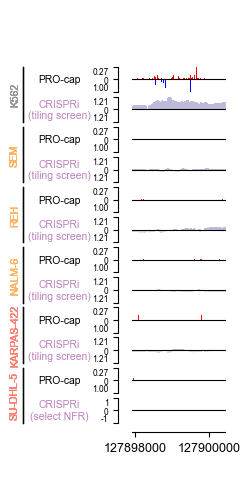

In [64]:
data, formatters, assay_colors = prepare_data(samples)
sample_full_colors = [colors[subtypes.index(labels[s][1])] for s in samples]
titles = [""]*len(regions)
outputfiles = [f"{PROJECT_DIR_o2}figures/ExtDataFig9c_{n+1}.pdf" for n in range(len(regions))]
plot_regions(data, formatters, regions, titles, texts, assay_colors, samples, sample_full_colors, (1.2, 4.8), outputfiles, xspace=-1.5, yspace=-0.78, x1=-0.85, x2=-0.78, xlabel="", yticklabel_fontsize=6, ylabel_fontsize=7.5)

### Main figure

In [54]:
samples_main = ["K562", "SEM", "REH", "Karpas422"]
texts_main = []
for s in samples_main:
    texts_main.extend(["PRO-cap", "CRISPRi"])
data_main, formatters_main, assay_colors_main = prepare_data(samples_main)
sample_main_colors = [colors[subtypes.index(labels[s][1])] for s in samples_main]

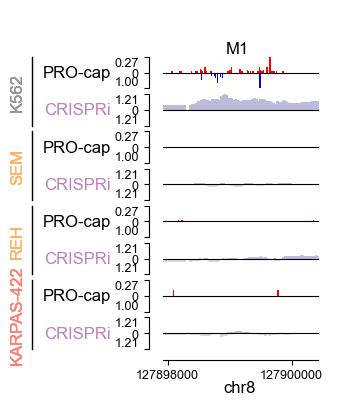

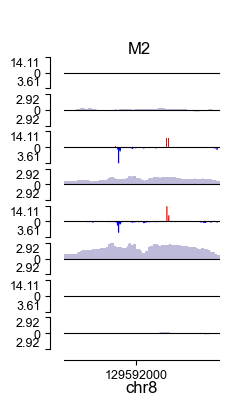

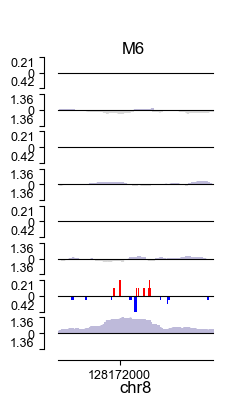

In [55]:
regions_main = [# M1
            ("chr8", "127897918", "127900416"),
           # M2 (BENC-D)
            ("chr8", "129590844", "129593342"),
            # M6 (GME-1)
            ("chr8", "128171008", "128173506")
          ]
titles = ["M1", "M2", "M6"]
outputfiles = [f"{PROJECT_DIR_o2}figures/Fig6b_{n+1}.pdf" for n in range(len(regions))]
plot_regions(data_main, formatters_main, regions_main, titles, texts_main, assay_colors, samples_main, sample_main_colors, (2, 4), outputfiles, xspace=-1, yspace=-0.55, x1=-0.6, x2=-0.53)